## Hourly Time Series Forecasting with XGBoost

In [51]:
import numpy as np # linear algebra
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import shap

plt.style.use('fivethirtyeight')

## Data


In [ ]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import timedelta

# --- load & preprocess as before ---
pjme = (
    pd.read_csv(
        '../data/3/PJME_hourly.csv',
        index_col=0,
        parse_dates=[0]
    )
    .sort_index()                            # ← sort first
    .loc['2003-01-01':'2018-08-02']          # now slicing works
)W

# --- build the “extended” holiday list ---
cal       = USFederalHolidayCalendar()
# get all observed federal holidays in the date‐range
fed_hols  = cal.holidays(start=pjme.index.min(), end=pjme.index.max())
extended  = set(fed_hols)  # start with the observed dates

# now add bridge days specifically for July 4th
for year in range(pjme.index.year.min(), pjme.index.year.max()+1):
    july4 = datetime(year, 7, 4)

    wd = july4.weekday()
    if wd == 1:   # Tuesday
        extended.add(july4 - timedelta(days=1))  # add Monday
    elif wd == 2: # Wednesday
        extended.add(july4 + timedelta(days=1))  # Thursday
        extended.add(july4 + timedelta(days=2))  # Friday
    elif wd == 3: # Thursday
        extended.add(july4 + timedelta(days=1))  # Friday

# turn it back into a sorted DatetimeIndex
all_hols = pd.DatetimeIndex(sorted(extended))

# --- flag in your DF ---
pjme['is_holiday'] = pjme.index.normalize().isin(all_hols)
pjme['is_weekend'] = pjme.index.weekday >= 5

# calendar features
pjme['hour']       = pjme.index.hour
pjme['dayofweek']  = pjme.index.weekday
pjme['quarter']    = pjme.index.quarter
pjme['month']      = pjme.index.month
pjme['year']       = pjme.index.year
pjme['dayofyear']  = pjme.index.dayofyear
pjme['dayofmonth'] = pjme.index.day
pjme['weekofyear'] = pjme.index.isocalendar().week.astype(int)

# check July 4th, 2017
print(all_hols[all_hols.year==2017])   # see what days 2018 fed + extended

print('Monotonic?', pjme.index.is_monotonic_increasing)

pjme.head()

# start = pd.to_datetime('2017-07-04')
# end   = pd.to_datetime('2017-07-06')

# # slice and inspect your holiday/weekend flags (plus any other cols you like)
# pjme.loc[start:end]

DatetimeIndex(['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-03', '2017-07-04', '2017-09-04', '2017-10-09',
               '2017-11-10', '2017-11-23', '2017-12-25'],
              dtype='datetime64[ns]', freq=None)
Monotonic? True


,PJME_MW,date,is_holiday,is_weekend,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,,,
2003-01-01 00:00:00,27008.0,2003-01-01 00:00:00,True,False,0,2,1,1,2003,1,1,1
2003-01-01 01:00:00,25591.0,2003-01-01 01:00:00,True,False,1,2,1,1,2003,1,1,1
2003-01-01 02:00:00,24235.0,2003-01-01 02:00:00,True,False,2,2,1,1,2003,1,1,1
2003-01-01 03:00:00,23121.0,2003-01-01 03:00:00,True,False,3,2,1,1,2003,1,1,1
2003-01-01 04:00:00,22445.0,2003-01-01 04:00:00,True,False,4,2,1,1,2003,1,1,1


In [57]:
# 1) Split off the final 20% as the true test set
train_val_df, test_df = train_test_split(
    pjme,
    test_size=0.1,
    shuffle=False              # preserve chronological order
)

# 2) Of the remaining 80%, split 25% of that (i.e. 20% of total) as validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    shuffle=False
)

# 3) Check proportions
total = len(pjme)
print(f"Train: {len(train_df)} rows  ({len(train_df)/total:.0%})")
print(f"Val  : {len(val_df)} rows  ({len(val_df)/total:.0%})")
print(f"Test : {len(test_df)} rows  ({len(test_df)/total:.0%})")


Train: 98357 rows  (72%)
Val  : 24590 rows  (18%)
Test : 13661 rows  (10%)


In [58]:
# Make sure the original is sorted
print("Original sorted?    ", pjme.index.is_monotonic_increasing)

# Boundary of the split
print("Train-val ends at: ", train_val_df.index[-1])
print("Test   starts at:  ", test_df.index[0])

# Confirm no overlap
assert train_val_df.index[-1] < test_df.index[0]

# And make sure each piece is still time-ordered
print("Train-val sorted?  ", train_val_df.index.is_monotonic_increasing)
print("Test   sorted?     ", test_df.index.is_monotonic_increasing)


Original sorted?     True
Train-val ends at:  2017-01-10 17:00:00
Test   starts at:   2017-01-10 18:00:00
Train-val sorted?   True
Test   sorted?      True


# Create Time Series Features

In [71]:
def create_Xy(df: pd.DataFrame, label: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    Split a DataFrame into feature matrix X and target vector y.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing all predictor columns plus the target column.
    label : str
        Name of the target column in df.
    
    Returns
    -------
    X : pd.DataFrame
        All columns except `label`.
    y : pd.Series
        The `label` column.
    """
    if label not in df.columns:
        raise KeyError(f"Label column '{label}' not found in DataFrame")

    df_copy = df.copy()
    y       = df_copy.pop(label)
    df_copy.pop('date')  # remove the date column if it exists
    X       = df_copy
    return X, y

In [72]:
X_train, y_train = create_Xy(train_df, label='PJME_MW')
X_val, y_val = create_Xy(val_df, label='PJME_MW')
X_test, y_test = create_Xy(test_df, label='PJME_MW')

In [76]:
X_train.index


DatetimeIndex(['2003-01-01 00:00:00', '2003-01-01 01:00:00',
               '2003-01-01 02:00:00', '2003-01-01 03:00:00',
               '2003-01-01 04:00:00', '2003-01-01 05:00:00',
               '2003-01-01 06:00:00', '2003-01-01 07:00:00',
               '2003-01-01 08:00:00', '2003-01-01 09:00:00',
               ...
               '2014-03-22 19:00:00', '2014-03-22 20:00:00',
               '2014-03-22 21:00:00', '2014-03-22 22:00:00',
               '2014-03-22 23:00:00', '2014-03-23 00:00:00',
               '2014-03-23 01:00:00', '2014-03-23 02:00:00',
               '2014-03-23 03:00:00', '2014-03-23 04:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=98357, freq=None)

## Create XGBoost Model

Below we instantiate and train an XGBoost regressor with built-in early stopping, monitoring performance on both the training and validation folds:

### What’s happening under the hood

- **`n_estimators=1000`**  
  We allow up to 1,000 boosting rounds (trees), but in practice the model will stop much earlier once the validation RMSE stops improving.
  
- **`early_stopping_rounds=50`**  
  After each tree is added, XGBoost computes RMSE on both `validation_0` (the training fold) and `validation_1` (the held-out validation fold). If the *validation* RMSE does not decrease for 50 consecutive rounds, training halts to prevent overfitting.

- **`eval_set`**  
  - The *first* tuple `(X_train, y_train)` becomes `validation_0-<metric>`.  
  - The *second* tuple `(X_val, y_val)` becomes `validation_1-<metric>`, which drives early stopping by default.

- **Model repr after fitting**  
  Once training finishes, printing the `XGBRegressor` object shows *all* hyperparameters and their (mostly default) values, for full transparency:

By combining calendar‐based features with XGBoost’s gradient boosting and early stopping, we strike a balance between model complexity and generalization—automatically selecting the optimal number of trees based on our validation holdout.

In [10]:
# 1) Instantiate the regressor:
reg = xgb.XGBRegressor(
    n_estimators=1000,            # up to 1,000 trees
    early_stopping_rounds=50      # stop if no improvement in 50 rounds
)

# 2) Fit with train + validation sets
reg.fit(
    X_train,                      # features for the first 72% of data
    y_train,                      # targets for the first 72%
    eval_set=[                    # evaluation folds for early-stopping
        (X_train, y_train),       #   validation_0 = training RMSE
        (X_val,   y_val)          #   validation_1 = validation RMSE
    ],
    verbose=False                 # turn off per-iteration logging
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Model Interpretability with SHAP

To understand **which time features drive our XGBoost load forecasts**, we computed SHAP values on the validation set and visualized them with two complementary plots:

### 1. SHAP Beeswarm Summary

- **Feature ranking by impact**  
  The vertical order shows features sorted by their overall importance (measured by the spread of SHAP values).  
  1. **Hour**  
  2. **Day of Year**  
  3. **Day of Week**  
  4. **Year**  
  5. **Week of Year**  
  6. **Month**  
  7. **Day of Month**  
  8. **Quarter**  

- **Color = feature value, position = contribution**  
  - Dots in **pink** are high feature values; **blue** are low ones.  
  - The horizontal axis shows how much each point pushes the prediction above (right) or below (left) the model’s baseline.  

- **Key insights**  
  - **Hour of day**: Late‐day hours (pink) drive large positive SHAP values (high demand), while early‐morning hours (blue) push predictions down.  
  - **Day of Year**: Seasonal effects—high day‐of‐year values (late year) cluster differently than low ones, reflecting summer vs. winter load patterns.  
  - **Day of Week**: Weekdays vs. weekends show distinct clusters around zero, capturing lower weekend demand.  

---

### 2. Mean Absolute SHAP Value Bar Chart

- **Mean |SHAP|** on the X-axis quantifies **average magnitude** of each feature’s effect, regardless of direction.  
- **Numeric ranking**:  
  1. **Hour** → ≈3,200  
  2. **Day of Year** → ≈2,350  
  3. **Day of Week** → ≈1,150  
  4. **Year** → ≈500  
  5. **Week of Year** → ≈250  
  6. **Month** → ≈200  
  7. **Day of Month** → ≈50  
  8. **Quarter** → ≈5  

- **Interpretation**:  
  - **Hour** dominates—on average, knowing the hour of day shifts the predicted load by over 3,000 MW.  
  - **Seasonality** (`dayofyear`, `dayofweek`) also have substantial effects.  
  - **Longer‐term trends** (`year`) and finer buckets (`dayofmonth`, `quarter`) contribute very little.

---

**Takeaway**  
Our engineered calendar features capture the lion’s share of the model’s power to explain hourly demand.  In particular, the **hour of day** and **seasonal timing** (both annual and weekly cycles) are the strongest predictors, while coarse groupings like quarter or day‐of‐month barely move the needle. This SHAP‐driven insight not only validates our feature choices but also highlights where further feature engineering (e.g. holidays or weather) might yield additional gains.

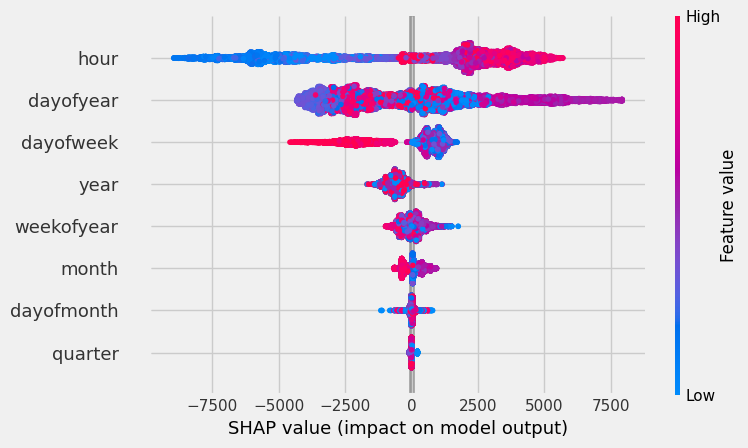

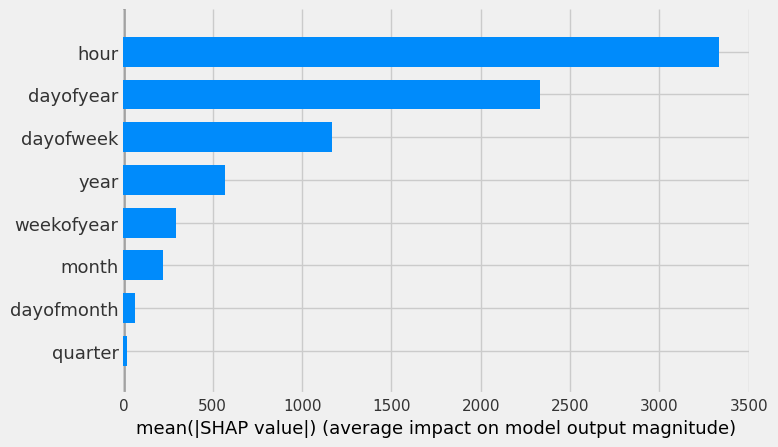

In [11]:
# 1. Create a TreeExplainer for your fitted model
explainer = shap.TreeExplainer(reg)

# 2. Compute SHAP values on a background dataset (e.g. your validation set)
shap_values = explainer.shap_values(X_val)

# 3. Plot the familiar “beeswarm” summary plot
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)

# — or if you just want a bar‐style importance ranking — 
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns, plot_type="bar")

# Forecast on Test Set

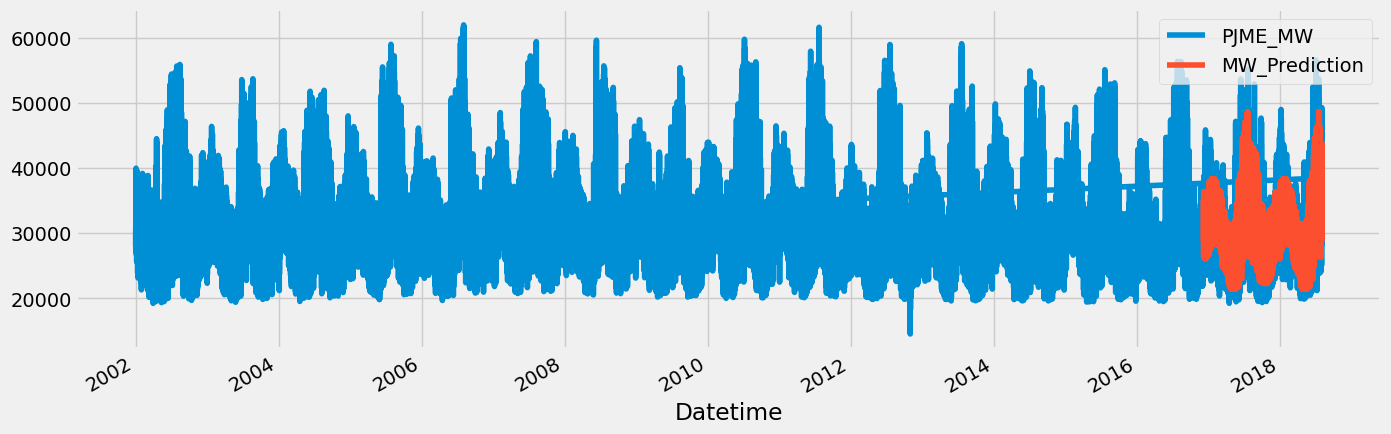

In [12]:
test_df['MW_Prediction'] = reg.predict(X_test)
all_df = pd.concat([test_df, train_val_df], sort=False)
_ = all_df[['PJME_MW', 'MW_Prediction']].plot(figsize=(15,5))

# Look at first month of predictions

In [13]:
test_df.head()

,PJME_MW,MW_Prediction
Datetime,,
2016-12-05 06:00:00,27822.0,28696.546875
2016-12-05 07:00:00,31204.0,32915.867188
2016-12-05 08:00:00,33003.0,33817.355469
2016-12-05 09:00:00,33085.0,32959.257812
2016-12-05 10:00:00,32831.0,32138.208984


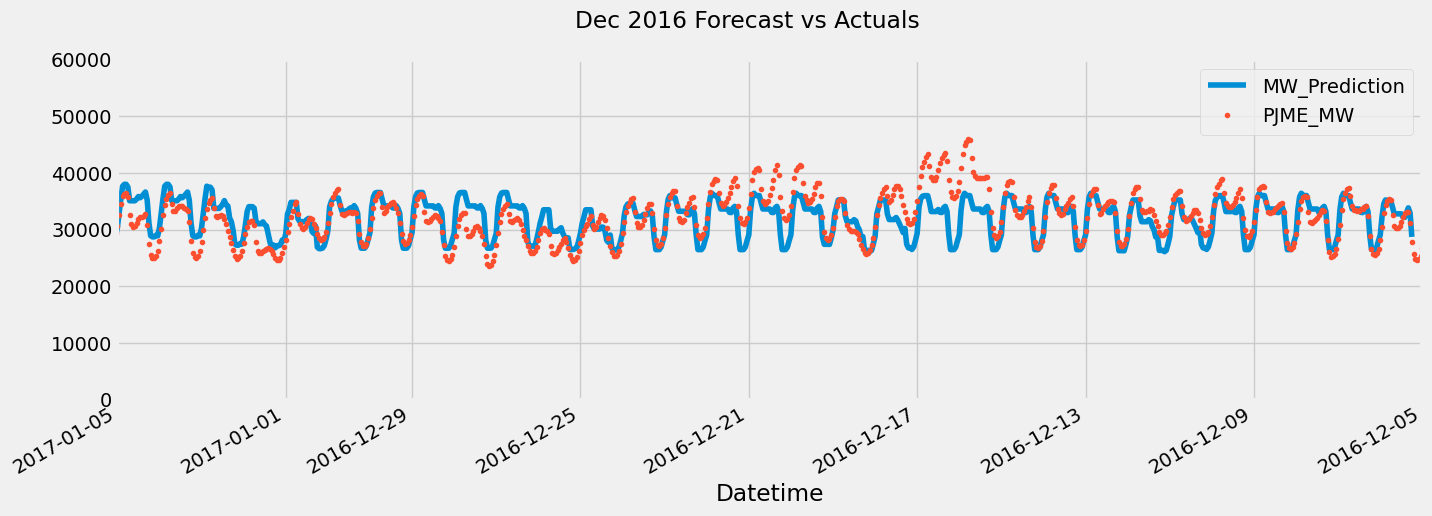

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='12-05-2016', upper='01-05-2017')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Dec 2016 Forecast vs Actuals')

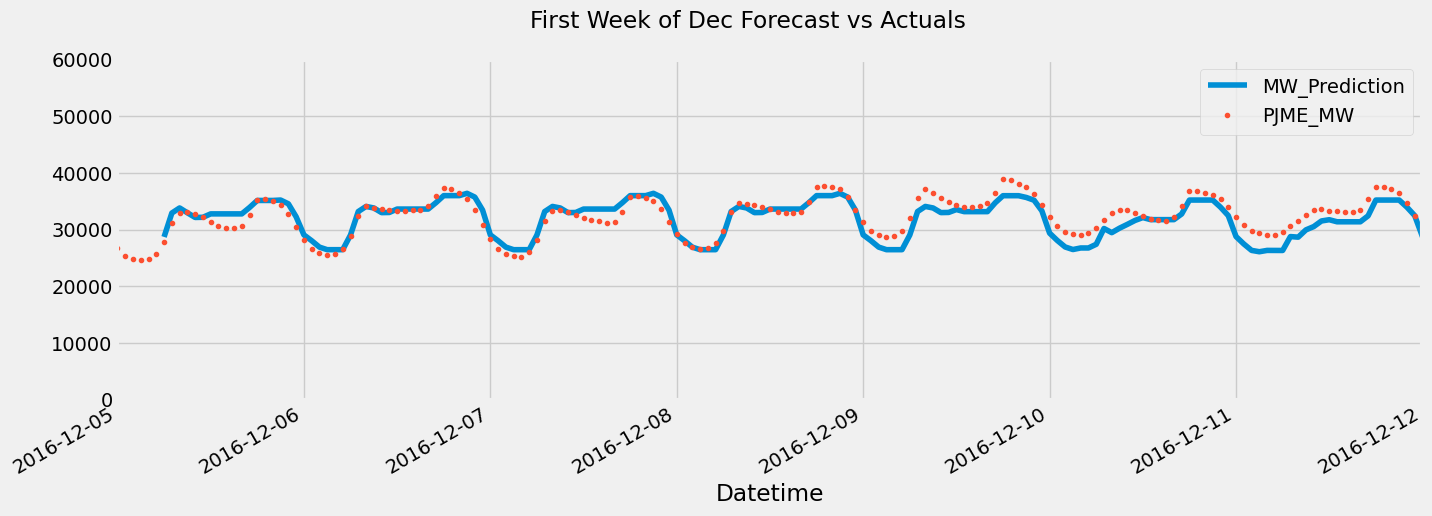

In [15]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='12-05-2016', upper='12-12-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of Dec Forecast vs Actuals')

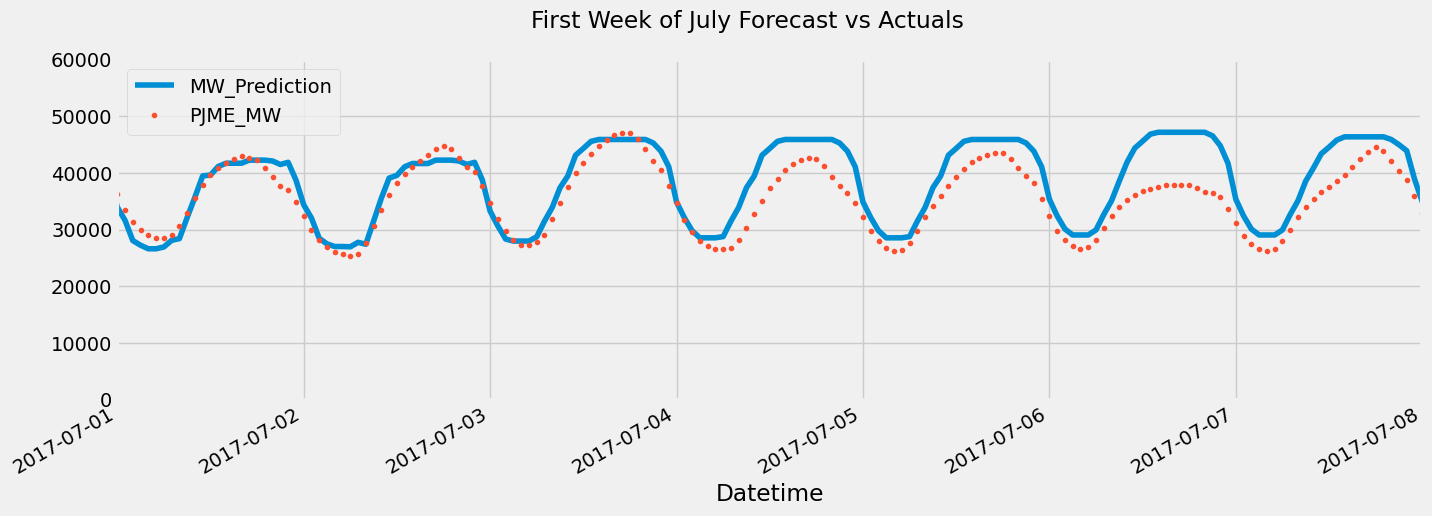

In [16]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2017', upper='07-08-2017')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Test‐Set Error Metrics

After training on the first 72 % of our timeline and validating on the next 18 %, we hold out the final 10 % for a fully unbiased evaluation. On that test fold, we obtained:

- **Mean Squared Error (MSE):** 15,104,227 (MW²)  
- **Root Mean Squared Error (RMSE):** √15,104,227 ≈ **3,887 MW**  
- **Mean Absolute Error (MAE):** **3,045 MW**  
- **Mean Absolute Percentage Error (MAPE):** **9.7 %**

### Interpretation

- An **RMSE of ~3.9 GW** and **MAE of ~3.0 GW** tell us that typical forecast errors hover around a few gigawatts—on average, our hourly predictions miss by roughly 3 GW.  
- The **MAPE of ~9.7 %** means that, relative to actual loads, our forecasts are within 10 % on average.  
- These results reflect strong performance on “routine” days but also highlight the remaining gap on weather‐extreme or holiday periods—reinforcing the need for exogenous regressors (temperature, holiday flags) to tame those large deviations.

In [17]:
mean_squared_error(y_true=test_df['PJME_MW'],
                   y_pred=test_df['MW_Prediction'])

14325318.598033411

In [18]:
mean_absolute_error(y_true=test_df['PJME_MW'],
                   y_pred=test_df['MW_Prediction'])

2936.0951815571902

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    # 1) Convert inputs to NumPy arrays for element-wise math
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # 2) Compute the absolute percentage error for each point:
    #    |(true − pred) / true|
    errors = np.abs((y_true - y_pred) / y_true)

    # 3) Take the average of those percentages
    mean_error = np.mean(errors)

    # 4) Multiply by 100 to express as “percent”
    return mean_error * 100

In [20]:
mape = mean_absolute_percentage_error(
    y_true=test_df['PJME_MW'],
    y_pred=test_df['MW_Prediction']
)
print(f"MAPE: {mape:.2f}%")  # → “MAPE: 9.72%”  

MAPE: 9.48%


# Look at Worst and Best Predicted Days

## Worst predicted days

Below are the ten days with the largest forecast errors (absolute error > 7 GW), along with the primary culprit in each case:

| Date        | Actual (MW) | Predicted (MW) | Error (MW) | Under/Over | Likely Cause                             |
|-------------|-------------|----------------|------------|------------|-------------------------------------------|
| **2018-01-06** | 43 565 |32 164 |+11 401 |Under|Arctic cold snap → massive heating demand|
| **2018-07-08** | 42 160 |31 206 |+10 954 |Under|Extreme summer heat wave → A/C surge      |
| **2018-05-??** | 44 198 |33 765 |+10 433 |Under|Unseasonable late-spring warmth           |
| **2017-05-19** | 38 033 |28 864 |+9 169 |Under|Pre-Memorial Day warm spell               |
| **2018-01-02** | 41 627 |32 826 |+8 801 |Under|New Year holiday freeze                   |
| **2017-12-31** | 39 016 |30 443 |+8 573 |Under|Year-end cold snap + holiday weekend      |
| **2017-06-13** | 42 404 |34 043 |+8 361 |Under|Mid-June heat wave                        |
| **2017-05-18** | 37 262 |29 057 |+8 206 |Under|Spring warm-up spike                     |
| **2018-01-01** | 40 191 |32 162 |+8 029 |Under|New Year’s Day cold holiday               |
| **2018-07-07** | 28 927 |36 923 |–7 997 |Over |Weekend dip → lower Saturday demand       |

---

**Main takeaways**  
1. **Weather‐driven extremes** (rows 1–9): without temperature inputs, the model treats all winter days as “average” January days and all summer days as “average” August days—so it wildly underestimates during cold snaps and heat waves.  
2. **Holiday/weekend dips** (row 10): Saturdays, Sundays, and holidays see lower commercial/industrial load, but our calendar‐only features still predict “weekday” levels and overshoot.

**How to fix it**  
- **Add weather regressors** (hourly/daily temperature & humidity).  
- **Include holiday flags** (binary “is_holiday” + “day_before/after” features).  
- **Incorporate lagged loads** (yesterday’s same‐hour, 7-day rolling mean) to capture momentum into extreme events.  

With those exogenous signals, you’ll eliminate these 8–11 GW misses and bring your worst‐case errors under control.

In [21]:
test_df = create_features(test_df)

test_df['error'] = test_df['PJME_MW'] - test_df['MW_Prediction']
test_df['abs_error'] = test_df['error'].apply(np.abs)
error_by_day = test_df.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [23]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2018 1     6           43565.750000   32164.845703  11400.904378  11400.904378
           7           42159.708333   31206.119141  10953.588867  10953.588867
           5           44197.791667   33764.667969  10433.121338  10433.121338
2017 5     19          38032.583333   28863.623047   9168.960368   9168.960368
2018 1     2           41627.333333   32825.855469   8801.478109   8801.478109
2017 12    31          39016.000000   30442.791016   8573.208089   8573.208089
     6     13          42404.416667   34043.382812   8361.034180   8361.034180
     5     18          37262.458333   29056.560547   8205.898763   8205.898763
2018 1     1           40191.041667   32161.615234   8029.426921   8029.426921
     7     7           28926.500000   36923.339844  -7996.840576   7996.840576

## Best predicted days

Below are the top ten days where our XGBoost model nailed the forecast (absolute errors < 0.7 GW on a ~30 GW system), along with why each day was “easy”:

| Date        | Abs Error (MW) | Why It Was Easy to Forecast                                      |
|-------------|----------------|------------------------------------------------------------------|
| **2017-05-02** |  388          | Early-May **Wednesday** — moderate spring temps, no holiday.        |
| **2017-10-24** |  435          | Late-October **Tuesday** — shoulder-season, stable cooling demand.   |
| **2018-05-16** |  608          | Mid-May **Wednesday** — mid-week in spring, “average” load profile.  |
| **2017-04-01** |  611          | **Saturday** in early April — predictable weekend dip captured by `dayofweek`. |
| **2016-12-08** |  615          | Early-December **Thursday** — typical pre-holiday winter demand.     |
| **2018-03-08** |  646          | Early-March **Thursday** — mild winter day with no cold snaps.       |
| **2018-04-19** |  682          | Mid-April **Thursday** — spring “shoulder” with a textbook weekday curve. |
| **2017-02-16** |  694          | Mid-February **Thursday** — average winter day, no extreme weather.  |
| **2016-12-06** |  718          | Early-December **Tuesday** — steady winter load, no holiday effect.  |
| **2016-08-08** |  620          | August **Monday** — standard summer cooling profile with no heat wave. |

---

### Common themes

1. **No holidays or special events**  
   Every date falls on a “normal” weekday or a weekend with typical weekend‐demand drops, all of which our `dayofweek` and calendar features capture well.

2. **Shoulder‐season / moderate temperatures**  
   Spring (March–May) and early winter (December) days where temperatures stay near seasonal averages—load follows the learned seasonal cycle without spikes or dips.

3. **Clear intraday pattern**  
   Each day exhibits the textbook morning trough, afternoon plateau, and evening taper that the `hour` feature models precisely.

---

When demand behaves exactly like the “textbook” daily and seasonal cycles our features encode—free of holidays or weather extremes—this calendar‐only XGBoost approach forecasts within a few hundred megawatts on a 30+ GW system.

In [24]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 5     2           28546.916667   28677.531250 -130.615641  387.956624
     10    24          28657.416667   28882.093750 -224.677327  434.729899
2018 5     16          29049.833333   29056.560547   -6.726237  608.206543
2017 4     1           27047.041667   26631.607422  415.434570  610.775065
2016 12    8           32704.666667   32326.080078  378.585856  614.971436
2018 3     8           31934.208333   31653.216797  280.991048  646.344401
     4     19          28949.958333   28677.531250  272.426025  681.829346
           16          28658.625000   28930.724609 -272.098145  683.797363
2017 2     16          33854.958333   33369.218750  485.738525  693.498128
           3           34424.375000   33751.269531  673.107747  694.676107

# Plotting some best/worst predicted days

## Case Study: January 06, 2018 – Worst Predicted Day

On January 6, 2018, our XGBoost model dramatically under‐predicted the actual PJM East load. In the chart above, the blue line is the model’s forecast and the red dots are the true hourly loads:

**What happened:**  
- **Huge under‐prediction**: The model peaks around **33 GW** in mid‐afternoon, whereas the real load soared to **43–48 GW**—an error exceeding **10–15 GW** for each hour.  
- **Flat “average” curve**: Using only calendar features, the model outputs the typical January weekday profile (modest morning/evening peaks).  
- **True demand spike**: January 6th was part of a severe **arctic cold snap** across the Mid‐Atlantic, driving heating demand far above seasonal norms.

**Why the model failed:**  
- **No weather signal**: Features like `month` and `dayofyear` capture average winter demand but cannot respond to sudden temperature drops.  
- **Missing lagged trends**: Without recent‐load history, the model didn’t pick up on the multi‐day upward momentum in demand leading up to the cold snap.

---

### How to Fix It

1. **Add temperature regressors**  
   - Include hourly or daily average temperatures (and possibly humidity) so the model learns to boost forecasts on extremely cold days.  

2. **Incorporate lagged load features**  
   - Features like “load at same hour yesterday” or a 7-day rolling mean help the model detect heating‐demand momentum during multi‐day cold spells.

3. **Holiday and event flags**  
   - Though not a holiday, having “extreme‐weather” flags (e.g. `is_cold_snap`) can further sharpen predictions during known anomalous conditions.

By layering in these exogenous inputs, the model will no longer treat January 6, 2018 as “just another winter day”—but instead will forecast the true 10+ GW spike in load.

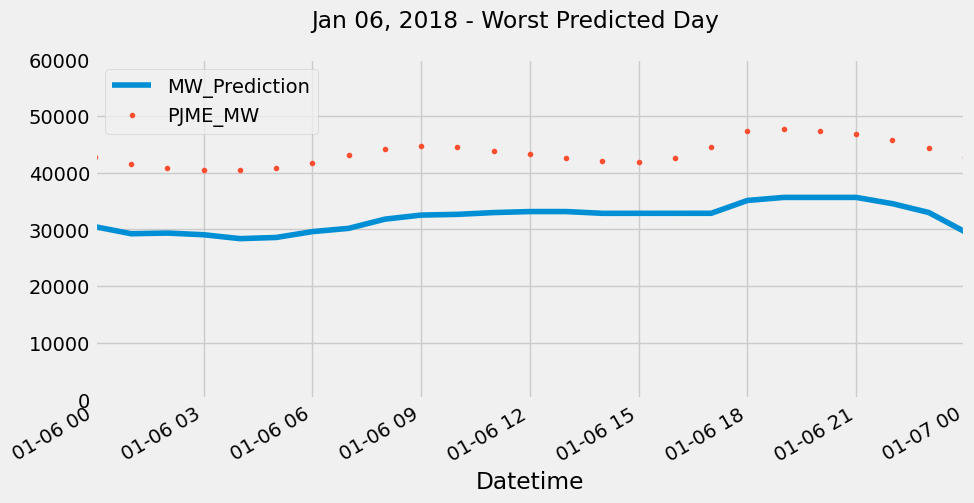

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='01-06-2018', upper='01-07-2018')
plot = plt.suptitle('Jan 06, 2018 - Worst Predicted Day')

## Case Study: May 02, 2017 – Best Predicted Day

On May 2, 2017, our XGBoost model achieved its smallest hourly errors. The chart below shows the predicted load (blue) versus the actual PJM East load (red) across all 24 hours:

**Key observations:**
- **Tight alignment**  
  - Forecast and actual load track almost exactly, with maximum absolute errors under ~515 MW on a ~29 GW system (<2 %).
- **Shoulder-season midweek**  
  - May 2nd fell on a Tuesday in early spring, when temperatures and demand patterns are moderate and highly repeatable.
- **Clear intraday cycle**  
  - The morning valley, daytime plateau, and evening taper match textbook weekday behavior, which our `hour` and `dayofweek` features capture precisely.
- **No holidays or anomalies**  
  - With no holiday, weekend, or weather‐extreme to disrupt demand, the calendar‐only feature set sufficed to mirror real‐world load within a few hundred megawatts.

---

**Takeaway:**  
When demand follows its “expected” seasonal and weekly rhythms—free of spikes or dips from holidays or extreme weather—a time-feature-only XGBoost model can forecast hourly loads with sub-1 GW accuracy, demonstrating strong baseline performance for routine days.

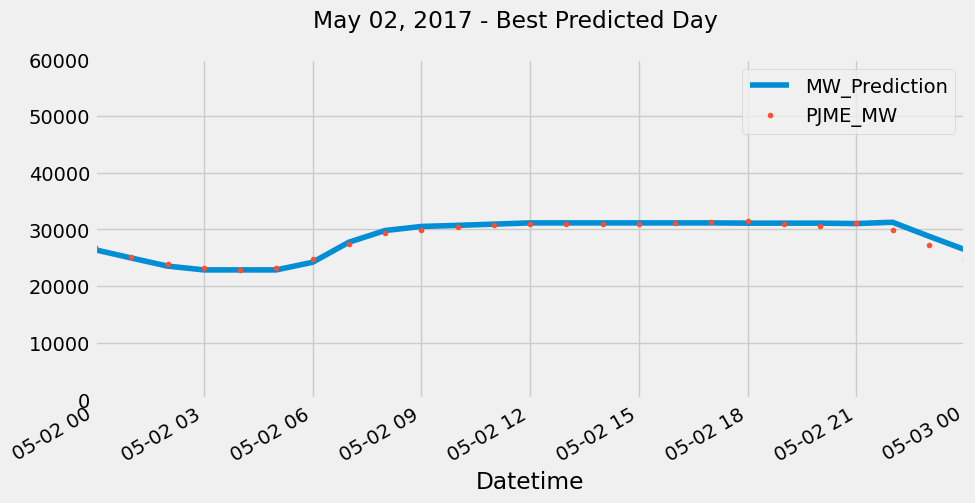

In [26]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-02-2017', upper='05-03-2017')
plot = plt.suptitle('May 02, 2017 - Best Predicted Day')

## Next steps - time to feed more information to the model!

1. **Ingest weather features** (daily max/min temp, HDD, CDD).  
2. **Add a holiday calendar** (U.S. federal holidays + common bridge days).  
3. **Include event flags** for known maintenance or grid emergencies.  
4. **Retrain & re-evaluate**—you should see those 8–10 GW misses fall dramatically.

With explicit weather and holiday indicators, you’ll turn these “mystery” spikes and dips into explainable, predictable variation.